# Nonlinear Convection Equation

The **1D nonlinear convection equation** describes how waves steepen as they propagate (like ocean waves approaching shore):

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

**Where:**

* $u(t, x)$ = velocity at position $x$ and time $t$
* $u \frac{\partial u}{\partial x}$ = nonlinear convection term (causes wave steepening)

**Physical meaning:** Tall parts of the wave travel faster than short parts, causing the wave to steepen over time.

In [1]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax

import jax.numpy as jnp

import copy

# Problem parameters

L = 1.0  # length of domain
T = 1.0  # final time

# 1. Initial Condition points (10 points at t=0)
t_ic = jnp.zeros((10, 1))
x_ic = jnp.linspace(0, 1, 10).reshape(-1, 1)
u_ic = jnp.sin(jnp.pi * x_ic)


# 2. Boundary Condition points (20 total: 10 at each edge)

"""
# Using Dirichlet boundaries: u(0, t) = 0, u(L, t) = 0 - fixed values at edges

# Left boundary (x=0):
t_bc_left = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_right = jnp.ones((10, 1))

# Combine them:
t_bc = jnp.concatenate([t_bc_left, t_bc_right])
x_bc = jnp.concatenate([x_bc_left, x_bc_right])
u_bc = jnp.zeros((20, 1))
"""
# Using periodic boundaries

# Left boundary (x=0):
t_bc_left = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_right = jnp.ones((10, 1))


# 3. Physics collocation points (30×30 = 900 points)
t_vals = jnp.linspace(0, 1, 30)
x_vals = jnp.linspace(0, 1, 30)
T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
t_physics = T_grid.reshape(-1, 1)
x_physics = X_grid.reshape(-1, 1)



# Neural Network

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., [2, 32, 32, 32, 1]
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x


# Calculate Residual

def physics_residual_single(params, t_point, x_point):

    def u(t_val, x_val):
        tx_in = jnp.array([[t_val, x_val]])
        return network(params, tx_in)[0, 0]
    
    du_dt = grad(u, argnums=0)(t_point, x_point)

    du_dx = grad(u, argnums = 1)(t_point, x_point)

    u_ = u(t_point, x_point)

    return du_dt + u_ * du_dx
    

# Vectorize to handle all physics points at once
# So vmap will call physics_residual_single 900 times, once for each (t, x) pair, keeping params fixed.
physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0))


# Initialize network
key = random.PRNGKey(123)
layer_sizes = [2, 32, 32, 32, 1]  # 2 inputs (t, x), 1 output (u)
params = init_network_params(layer_sizes, key)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def update_step(params, opt_state, t_ic, x_ic, u_ic, 
                t_bc_left, x_bc_left, t_bc_right, x_bc_right, t_physics, x_physics):

    def loss_fn(params):
        # 1. Initial Condition Loss
        # Network prediction at IC points
        tx_ic = jnp.concatenate([t_ic, x_ic], axis=1)  # Combine t and x
        u_pred_ic = network(params, tx_ic)
        ic_loss = jnp.mean((u_pred_ic - u_ic)**2)
        
        # 2. Boundary Condition Loss

        """
        # Dirichlet boundaries
        tx_bc = jnp.concatenate([t_bc, x_bc], axis=1)
        u_pred_bc = network(params, tx_bc)
        bc_loss = jnp.mean((u_pred_bc - u_bc)**2)
        """

        tx_bc_left = jnp.concatenate([t_bc_left, x_bc_left], axis=1)
        u_pred_bc_left = network(params, tx_bc_left)

        tx_bc_right = jnp.concatenate([t_bc_right, x_bc_right], axis=1)
        u_pred_bc_right = network(params, tx_bc_right)

        bc_loss = jnp.mean((u_pred_bc_left - u_pred_bc_right)**2)

        # 3. Physics Loss
        physics_residuals = physics_residual_batch(params, 
                                                t_physics.ravel(), # (900,) not (900, 1)
                                                x_physics.ravel() # (900,) not (900, 1)
                                                )
        physics_loss = (1e-2) * jnp.mean(physics_residuals**2) # Physics residual is of 900 points. Much more than our ic and bc points. Therefore we multiply by 1e-4 so it doesn't overpower
        
        return ic_loss + bc_loss + physics_loss
    
        # Compute loss and gradients
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val


# Training parameters
num_iterations = 20000
save_every = 150  # Save every 150 iterations
print_every = 1000

# Storage for snapshots
snapshots = []
snapshot_iterations = []

# Prepare physics points (flatten for vmap)
t_phys_flat = t_physics.ravel()
x_phys_flat = x_physics.ravel()

# Training loop
losses = []
for i in range(num_iterations):
    params, opt_state, loss = update_step(
        params, opt_state,
        t_ic, x_ic, u_ic,
        t_bc_left, x_bc_left, t_bc_right, x_bc_right,
        t_phys_flat, x_phys_flat
        )
    
    losses.append(loss)


    # Save snapshot every 150 iterations
    if (i + 1) % save_every == 0:
        # Make a copy of params (important!)
        snapshots.append(copy.deepcopy(params))
        snapshot_iterations.append(i + 1)

    
    if (i + 1) % print_every == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss:.6f}")





Iteration 1000/20000, Loss: 0.001785
Iteration 2000/20000, Loss: 0.001312
Iteration 3000/20000, Loss: 0.001902
Iteration 4000/20000, Loss: 0.001044
Iteration 5000/20000, Loss: 0.000903
Iteration 6000/20000, Loss: 0.000789
Iteration 7000/20000, Loss: 0.000697
Iteration 8000/20000, Loss: 0.000700
Iteration 9000/20000, Loss: 0.000636
Iteration 10000/20000, Loss: 0.000625
Iteration 11000/20000, Loss: 0.000604
Iteration 12000/20000, Loss: 0.000590
Iteration 13000/20000, Loss: 0.000577
Iteration 14000/20000, Loss: 0.000564
Iteration 15000/20000, Loss: 0.000553
Iteration 16000/20000, Loss: 0.000544
Iteration 17000/20000, Loss: 0.000537
Iteration 18000/20000, Loss: 0.000632
Iteration 19000/20000, Loss: 0.000523
Iteration 20000/20000, Loss: 0.000517


# Plot Results

U_pred shape: (100, 100)


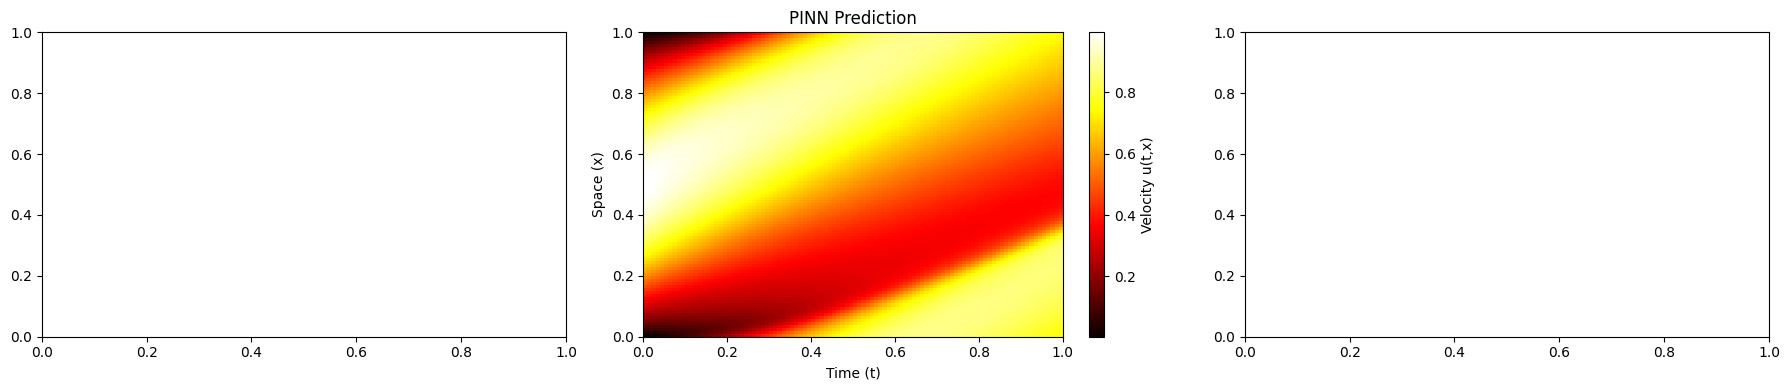

In [ ]:
# Generate the analytical solution over a dense grid

# Create dense grid for plotting (100x100 points)
t_plot = jnp.linspace(0, 1, 100)
x_plot = jnp.linspace(0, 1, 100)
T_plot, X_plot = jnp.meshgrid(t_plot, x_plot)


# Network prediction
TX_plot = jnp.stack([T_plot.ravel(), X_plot.ravel()], axis=1)  # (10000, 2)
U_pred_flat = network(params, TX_plot)
U_pred = U_pred_flat.reshape(100, 100)


print("U_pred shape:", U_pred.shape)


import matplotlib.pyplot as plt

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(18, 4))



# Plot 2: PINN prediction
im2 = axes[1].imshow(U_pred, extent=[0, 1, 0, 1], origin='lower',
                     aspect='auto', cmap='hot')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Space (x)')
axes[1].set_title('PINN Prediction')
plt.colorbar(im2, ax=axes[1], label='Velocity u(t,x)')


plt.tight_layout()
plt.savefig('convection_results.png', dpi=150, bbox_inches='tight')
plt.show()


### Plot Velocity Against x at different time frames

In [7]:
import matplotlib.pyplot as plt
import os

# Create directory for frames
os.makedirs('frames', exist_ok=True)

def plot_snapshot(params_snapshot, iteration):
    """Plot PINN predictions at 4 time slices"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    time_slices = [0.0, 0.25, 0.5, 0.75]
    x_vals = jnp.linspace(0, 1, 100)
    
    for idx, t_val in enumerate(time_slices):
        ax = axes[idx]
        
        # Initial condition (for reference at t=0)
        if t_val == 0.0:
            u_initial = jnp.sin(jnp.pi * x_vals)
            ax.plot(x_vals, u_initial, 'k--', linewidth=2, 
                   label='Initial Condition', alpha=0.5)
        
        # PINN prediction
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params_snapshot, tx_input).ravel()
        
        # Plot
        ax.plot(x_vals, u_pred, 'r-', linewidth=2.5, label='PINN Prediction')
        ax.set_xlabel('Space (x)', fontsize=11)
        ax.set_ylabel('u(x, t)', fontsize=11)
        ax.set_title(f't = {t_val:.2f}', fontsize=12, fontweight='bold')
        ax.set_ylim(-1.2, 1.2)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        
        # Add vertical line to show wave peak location
        peak_idx = jnp.argmax(u_pred)
        peak_x = x_vals[peak_idx]
        ax.axvline(peak_x, color='blue', linestyle=':', alpha=0.3, linewidth=1)
    
    plt.suptitle(f'Non-linear Convection PINN - Training Step: {iteration}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'frames/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames from snapshots
print("Generating frames...")
files = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_snapshot(params_snap, iteration)
    files.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

print(f"\nTotal frames: {len(files)}")

# Create GIF
from PIL import Image

def save_gif_PIL(outfile, files, fps=10, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

print("Creating GIF...")
save_gif_PIL("convection_pinn_learning.gif", files, fps=10, loop=0)
print("Done! Check convection_pinn_learning.gif")

Generating frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total frames: 133
Creating GIF...
Done! Check convection_pinn_learning.gif


### Plot Wave Evolution

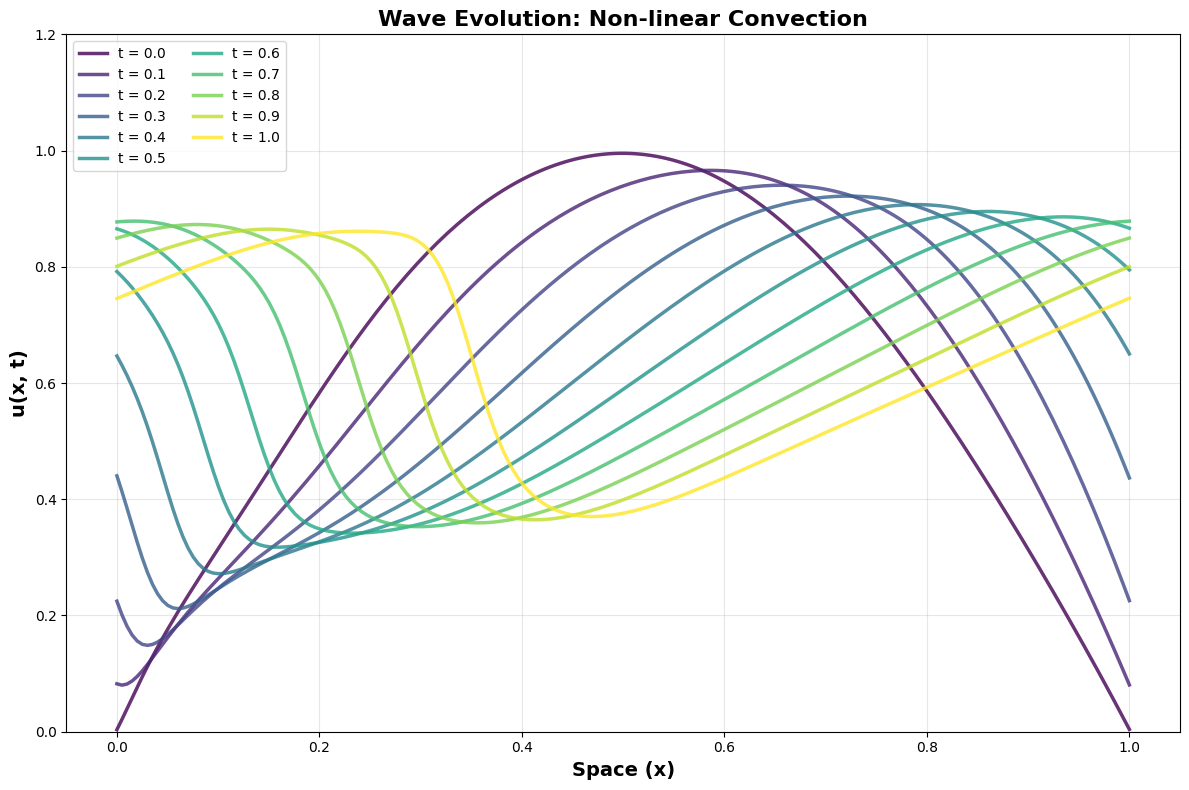

In [9]:
def plot_wave_evolution(params_final):
    """Plot u vs x at multiple time slices to see wave evolution"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # More time slices to see evolution better
    time_slices = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    x_vals = jnp.linspace(0, 1, 200)  # Higher resolution
    
    # Color map for progression
    colors = plt.cm.viridis(jnp.linspace(0, 1, len(time_slices)))
    
    for idx, t_val in enumerate(time_slices):
        # PINN prediction
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params_final, tx_input).ravel()
        
        # Plot with label
        label = f't = {t_val:.1f}'
        ax.plot(x_vals, u_pred, color=colors[idx], linewidth=2.5, 
                label=label, alpha=0.8)
    
    ax.set_xlabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_ylabel('u(x, t)', fontsize=14, fontweight='bold')
    ax.set_title('Wave Evolution: Non-linear Convection', 
                 fontsize=16, fontweight='bold')
    ax.set_ylim(0, 1.2)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', ncol=2, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('wave_evolution.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

# Use the final trained parameters
plot_wave_evolution(params)

### 3D Visualization

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Create directory
os.makedirs('frames_3d', exist_ok=True)

def plot_3d_surface(params_snapshot, iteration):
    """Plot 3D surface of u(t, x)"""
    fig = plt.figure(figsize=(12, 9))
    
    # Create grid
    t_vals = jnp.linspace(0, 1, 60)
    x_vals = jnp.linspace(0, 1, 60)
    T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
    
    # PINN prediction
    TX_flat = jnp.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
    U_pred_flat = network(params_snapshot, TX_flat)
    U_pred = U_pred_flat.reshape(60, 60)
    
    # Plot PINN prediction
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(T_grid, X_grid, U_pred, cmap='seismic', 
                           alpha=0.9, edgecolor='none',
                           vmin=-1.2, vmax=1.2)
    
    ax.set_xlabel('Time (t)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Space (x)', fontsize=12, fontweight='bold')
    ax.set_zlabel('u(x, t)', fontsize=12, fontweight='bold')
    ax.set_title('Non-linear Convection - PINN Prediction', fontsize=14, fontweight='bold')
    ax.set_zlim(-1.2, 1.2)
    ax.view_init(elev=25, azim=45)  # Set viewing angle
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.suptitle(f'Training Step: {iteration}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'frames_3d/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames
print("Generating 3D surface frames...")
files_3d = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_3d_surface(params_snap, iteration)
    files_3d.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

print(f"\nTotal 3D frames: {len(files_3d)}")

# Create GIF
print("Creating 3D GIF...")
save_gif_PIL("convection_pinn_3d_learning.gif", files_3d, fps=10, loop=0)
print("Done! Check convection_pinn_3d_learning.gif")

Generating 3D surface frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total 3D frames: 133
Creating 3D GIF...
Done! Check convection_pinn_3d_learning.gif
